## Stage 1: importing the dependecies

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import namedtuple, deque
import torch.optim as optim
import os.path
from os import path
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd


## Stage 2: building the brain of the agent

parameters:



*   state_size (int): dimension of each state
*   action_size (int): dimension of each action
*   seed (int): random seed
*   fc1_units (int): number of nodes in first hidden layer
*   fc2_units (int): number of nodes in second hidden layer
*   fc3_units (int): number of nodes in third hidden layer



In [0]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=32, fc2_units=64, fc3_units=130):
        """Initialize parameters and build model."""
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


## Stage 3: building the body of the agent

###  setting up parameters

In [0]:
BUFFER_SIZE = 1500      # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.95            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 0.001              # learning rate
update_every = 4        # update after every 4 episode

### checking for gpu otherwise use cpu

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###  building the body

function:

*   step(): save the sample on memory and call learn() 
*   learn(): use those sample to learn
*   act(): return action
*   soft_update(): update the target network slowly

parameters:



*   state_size (int): dimension of each state
*   action_size (int): dimension of each action
*   seed (int): random seed







In [0]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)        #only update the local network parameters

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step +1)%update_every
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        #set_trace()
        states, actions, rewards, next_states, dones = experiences          
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)    #updating the target network parameters                    

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

###  saving the sample in replay memory

function:

*   add() : add a new experience on memory
*   sample(): randomly sample a batch of experiences from memory

parameters:



*   action_size (int): dimension of each action
*   buffer_size (int): maximum size of buffer
*   batch_size (int): size of each training batch
*   seed (int): random seed




In [0]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)        
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Stage 4: data preprocessing 

### defining helper function

In [0]:
def sigmoid(x):
  return (1 / (1 + np.exp(-x)))

In [0]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

###  Loading ANN for trend analysis(classification)

#### loading ANN model

In [0]:
with open('GP classification with factor.json', 'r') as f:
    model_json = f.read()

classifier = tf.keras.models.model_from_json(model_json)
# load weights into new model
classifier.load_weights("GP classification with factor.json.h5")

#### loading the data

In [0]:
dataset_2 = pd.read_csv('GRAE Historical Data 2018 -2019practice.csv')
dataset_1 = pd.read_csv('GRAE Historical Data 2009-2017.csv')
sentiment = dataset_2.iloc[:, 16:17].values
X_classifier = dataset_2.iloc[:, [7,11,12,13,14]].values
y_classifier = dataset_2.iloc[:, 15:16].values

#### feature scaling

In [0]:
sc_1 = MinMaxScaler()
X_classifier = sc_1.fit_transform(X_classifier)

###  loading RNN for trend analysis(regression)

#### load the RNN model

In [0]:
with open('gp prediction with factor.json', 'r') as f:
    modelgp_json = f.read()

regressor = tf.keras.models.model_from_json(modelgp_json)

# load weights into new model
regressor.load_weights("gp prediction with factor.json.h5")

#### loading the data

In [0]:
dataset_test_1 = dataset_1.iloc[:,[1,7,11,12,13,14]]
dataset_test_1 = dataset_test_1.iloc[-60:,:] 
dataset_test_2 = dataset_2.iloc[:,[1,7,11,12,13,14]]
dataset_test = pd.concat([dataset_test_1, dataset_test_2], axis = 0, ignore_index=True, sort=False)
test_set = dataset_test.iloc[:,1:].values
test_set_y = dataset_test.iloc[:, 0:1].values

#### feature scaling

In [0]:
inputs = test_set[:,:]
sc_2 = MinMaxScaler(feature_range = (0, 1))
inputs = sc_1.transform(inputs)
test_set_scaled_y = sc_2.fit_transform(test_set_y)

#### making 60 timesteps, rank 3 tensor

In [0]:
X_regressor = []
for i in range(60, len(test_set)):
    X_regressor.append(inputs[i-60:i, :])

X_regressor[0] = np.reshape(X_regressor[0], (1,-1))
array = np.reshape(X_regressor[0],(1,60,-1))
 
for i in range(1,len(X_regressor)):
    X_regressor[i] = np.reshape(X_regressor[i],(1,-1))
    X_regressor[i] = np.reshape(X_regressor[i],(1,60,-1))
    array = np.vstack((array,X_regressor[i]))

X_regressor = array

y_regressor = []
for i in range(60,len(test_set_scaled_y)):
    y_regressor.append(test_set_scaled_y[i,0])

y_regressor = np.array(y_regressor)
y_regressor = np.reshape(y_regressor, (-1,1))


###  create state as an input for the neural network

In [0]:
def state_creator(data, timestep, window_size):
  
  starting_id = timestep - window_size + 1
  
  y_pred = classifier.predict(np.reshape(X_classifier[timestep],(1,-1)))
  
  if y_pred>0.5:
    y_pred = 1
  else:
    y_pred = 0

  #predicting the price
  predicted_next_price = sc_2.inverse_transform(regressor.predict(np.reshape(X_regressor[timestep],(1,X_regressor[timestep].shape[0],X_regressor[timestep].shape[1]))))[0,0]
  if timestep > 0:
    predicted_present_price = sc_2.inverse_transform(regressor.predict(np.reshape(X_regressor[timestep-1],(1,X_regressor[timestep-1].shape[0],X_regressor[timestep-1].shape[1]))))[0,0]
  else:
      predicted_present_price = predicted_next_price
      
  diffrence = predicted_next_price - predicted_present_price
  if diffrence>0:
      diffrence = 1
  else:
      diffrence = 0
      
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])

  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
  score = sentiment[timestep,0]
  state.append(y_pred)
  state.append(diffrence)
  state.append(score)
  state = np.array([state])
  state = np.reshape(state, (-1))
  return state


###  loading the training data for trading

In [0]:
dataset_2 = pd.read_csv('GRAE Historical Data 2018 -2019practice.csv')
data = list(dataset_2['Price'])
data_samples = len(data)-1

## Stage 5: agent performing action on the environment

###  making the dqn object

In [0]:
window_size = 10
trend_regression = 1
trend_classification = 1
sentiment_score = 1

agent = Agent(state_size = window_size+trend_regression+trend_classification+sentiment_score, action_size=3, seed=0)

###  function to act on the environment

*   n_episodes (int): maximum number of training episodes
*   max_t (int): maximum number of timesteps per episode
*   eps_start (float): starting value of epsilon, for epsilon-greedy action selection
*   eps_end(float): minimum value of epsilon
*   eps_decay(float): multiplicative factor (per epsiode) for decresing epsilon



In [0]:
scores = []

def dqn(n_episodes=5000, max_t=len(data)-1, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
  
    scores_window = deque(maxlen=50)  # last 50 scores
    eps = eps_start                    # initialize epsilon
    for episode in range(1, n_episodes+1):
        print("Episode: {}/{}".format(episode, n_episodes))
        state = state_creator(data, 0, window_size + 1)
        total_profit = 0        
        inventory_gp = []
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state = state_creator(data, t+1, window_size + 1)
            reward = 0
            if action == 1: #Buying gp
                inventory_gp.append(data[t])
                print("AI Trader bought: ", stocks_price_format(data[t]))

            if action == 2 and len(inventory_gp) > 0: #Selling gp
                #buy_price = inventory_gp.pop(0)
                buy_price = min(inventory_gp)
                inventory_gp.remove(buy_price)
                total_profit += (data[t] - buy_price)
                if data[t] - buy_price>0:
                    reward = 1
                elif data[t] - buy_price==0:
                    reward = 0
                else:
                    reward = -1
                print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price))
                
            if t == data_samples - 1:
                done = True
            else:
                done = False
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("########################")
                print("TOTAL PROFIT: {}".format(total_profit))
                scores.append(total_profit)
                print("########################")
            
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
    return total_profit


###  acting on the environment

In [0]:
scores = dqn()

Episode: 1/5000
AI Trader bought:  $ 472.000000
AI Trader sold:  $ 479.600000  Profit: $ 7.600000
AI Trader bought:  $ 486.000000
AI Trader bought:  $ 478.200000
AI Trader bought:  $ 472.600000
AI Trader bought:  $ 471.400000
AI Trader sold:  $ 476.000000  Profit: $ 4.600000
AI Trader sold:  $ 476.000000  Profit: $ 3.400000
AI Trader bought:  $ 473.600000
AI Trader sold:  $ 481.400000  Profit: $ 7.800000
AI Trader sold:  $ 483.300000  Profit: $ 5.100000
AI Trader bought:  $ 487.700000
AI Trader sold:  $ 494.400000  Profit: $ 8.400000
AI Trader sold:  $ 503.800000  Profit: $ 16.100000
AI Trader bought:  $ 510.300000
AI Trader sold:  $ 505.000000  Profit: - $ 5.300000
AI Trader bought:  $ 500.000000
AI Trader bought:  $ 496.300000
AI Trader sold:  $ 495.600000  Profit: - $ 0.700000
AI Trader bought:  $ 500.700000
AI Trader bought:  $ 508.700000
AI Trader bought:  $ 505.600000
AI Trader sold:  $ 507.700000  Profit: $ 7.700000
AI Trader sold:  $ 505.100000  Profit: $ 4.400000
AI Trader sol

KeyboardInterrupt: ignored

###  saviing the model weights and bias

In [0]:
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_qnetwork_local.pth')
torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_qnetwork_target.pth')

###  ploting totoal profit

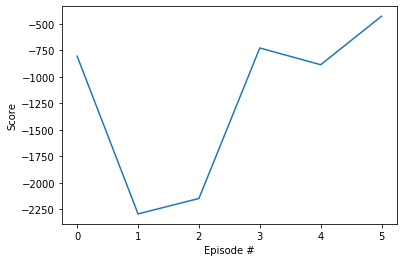

In [0]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

##  Stage 5: agent performing after 1000 iteration

###  loading the weights of the agent from file

In [52]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_qnetwork_local.pth'))

<All keys matched successfully>

### checking for gpu otherwise use cpu

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###  loading the training dataset

In [0]:
dataset = pd.read_csv('GRAE Historical Data 2018 -2019practice.csv')
data = list(dataset['Price'])

###  setting up parameters

In [0]:
data_samples = len(data)-1
inventory_gp = []
total_profit = 0

###  watching the agent performance on training set after 1000 iteration

In [56]:
state = state_creator(data, 0, window_size + 1)

for t in range(data_samples):
    next_state = state_creator(data, t+1, window_size + 1)
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    action = np.argmax(agent.qnetwork_local(state).cpu().data.numpy())
    if action == 1:
        inventory_gp.append(data[t])
        print("AI Trader bought: ", stocks_price_format(data[t]))
        
    if action == 2 and len(inventory_gp)>0:
        buy_price = min(inventory_gp)
        inventory_gp.remove(buy_price)
        total_profit += (data[t] - buy_price)
        print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price))
    state = next_state

print("########################")
print("TOTAL PROFIT: {}".format(total_profit))
print("########################")

AI Trader bought:  $ 486.000000
AI Trader bought:  $ 478.300000
AI Trader bought:  $ 470.900000
AI Trader sold:  $ 471.400000  Profit: $ 0.500000
AI Trader bought:  $ 476.000000
AI Trader bought:  $ 473.600000
AI Trader sold:  $ 479.800000  Profit: $ 6.200000
AI Trader sold:  $ 481.400000  Profit: $ 5.400000
AI Trader bought:  $ 483.300000
AI Trader sold:  $ 487.700000  Profit: $ 9.400000
AI Trader sold:  $ 494.400000  Profit: $ 11.100000
AI Trader sold:  $ 503.800000  Profit: $ 17.800000
AI Trader bought:  $ 505.300000
AI Trader sold:  $ 510.300000  Profit: $ 5.000000
AI Trader bought:  $ 505.000000
AI Trader bought:  $ 502.400000
AI Trader bought:  $ 496.300000
AI Trader bought:  $ 496.000000
AI Trader sold:  $ 497.100000  Profit: $ 1.100000
AI Trader sold:  $ 500.700000  Profit: $ 4.400000
AI Trader sold:  $ 508.700000  Profit: $ 6.300000
AI Trader sold:  $ 505.600000  Profit: $ 0.600000
AI Trader bought:  $ 505.100000
AI Trader sold:  $ 506.700000  Profit: $ 1.600000
AI Trader boug